In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import modulation_cycle_signal_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, get_df_mask_chan_signif, keep_clean
import mne
import os
from configuration import base_folder
from params import *

In [2]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [3]:
indexes = ['participant','session','chan']
metrics = ['amplitude']
metrics_with_psycho = ['amplitude','stai_state','stai_trait','Maia_Mean']

In [6]:
modulation = modulation_cycle_signal_concat_job.get(global_key).to_dataframe()
modulation = keep_clean(df_raw = modulation, metrics_to_clean = metrics)
modulation = modulation.iloc[:,1:]

In [7]:
modulation

,participant,session,chan,amplitude,stai_state,stai_trait,keep_session,Maia_Mean
0,P01,baseline,Fp1,0.000002,40,61,1,1.019643
1,P01,baseline,Fz,0.000002,40,61,1,1.019643
2,P01,baseline,F3,0.000003,40,61,1,1.019643
3,P01,baseline,F7,0.000005,40,61,1,1.019643
4,P01,baseline,FT9,0.000006,40,61,1,1.019643
...,...,...,...,...,...,...,...,...
2785,P31,odor,FC6,0.000006,29,40,1,2.790774
2786,P31,odor,FC2,0.000004,29,40,1,2.790774
2787,P31,odor,F4,0.000007,29,40,1,2.790774
2788,P31,odor,F8,0.000007,29,40,1,2.790774


In [8]:
modulation['keep_session'].value_counts()

keep_session
1    2697
0      93
Name: count, dtype: int64

<AxesSubplot: >

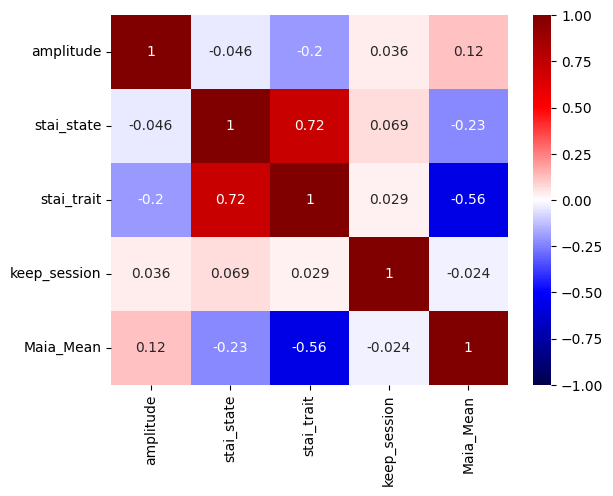

In [9]:
sns.heatmap(modulation.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [10]:
modulation

,participant,session,chan,amplitude,stai_state,stai_trait,keep_session,Maia_Mean
0,P01,baseline,Fp1,0.000002,40,61,1,1.019643
1,P01,baseline,Fz,0.000002,40,61,1,1.019643
2,P01,baseline,F3,0.000003,40,61,1,1.019643
3,P01,baseline,F7,0.000005,40,61,1,1.019643
4,P01,baseline,FT9,0.000006,40,61,1,1.019643
...,...,...,...,...,...,...,...,...
2785,P31,odor,FC6,0.000006,29,40,1,2.790774
2786,P31,odor,FC2,0.000004,29,40,1,2.790774
2787,P31,odor,F4,0.000007,29,40,1,2.790774
2788,P31,odor,F8,0.000007,29,40,1,2.790774


In [11]:
modulation_baselined = df_baseline(df = modulation, indexes = indexes, metrics= metrics, mode = 'ratio')

In [12]:
modulation_baselined

,participant,session,chan,amplitude
0,P01,odor,Fp1,1.297812
1,P01,odor,Fz,1.246406
2,P01,odor,F3,1.039571
3,P01,odor,F7,0.695761
4,P01,odor,FT9,0.768943
...,...,...,...,...
1855,P31,music,FC6,2.213367
1856,P31,music,FC2,1.538058
1857,P31,music,F4,1.911542
1858,P31,music,F8,1.853576


<AxesSubplot: xlabel='chan', ylabel='amplitude'>

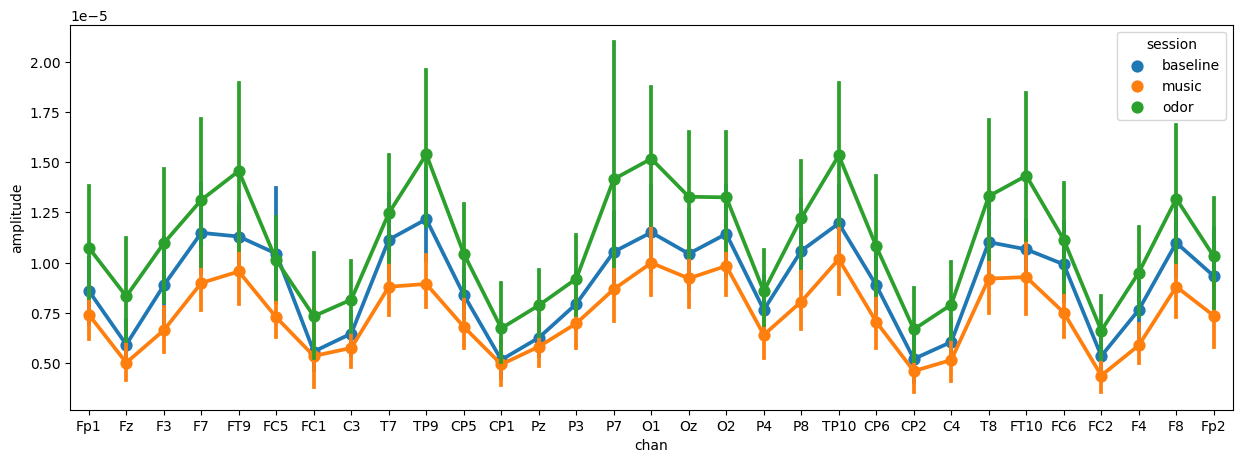

In [14]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = modulation, x = 'chan', y = 'amplitude', hue = 'session',ax=ax)

<AxesSubplot: xlabel='chan', ylabel='amplitude'>

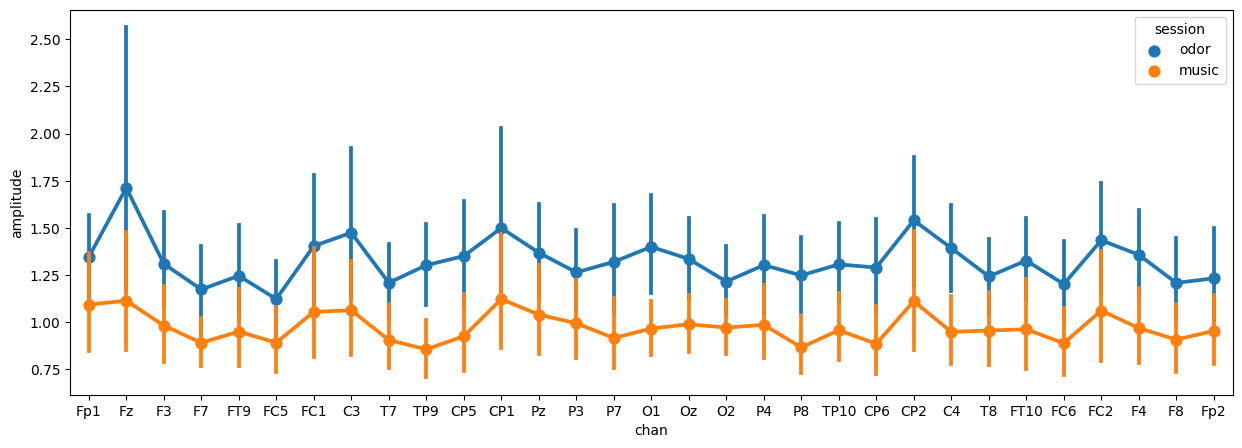

In [15]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = modulation_baselined, x = 'chan', y = 'amplitude', hue = 'session',ax=ax)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


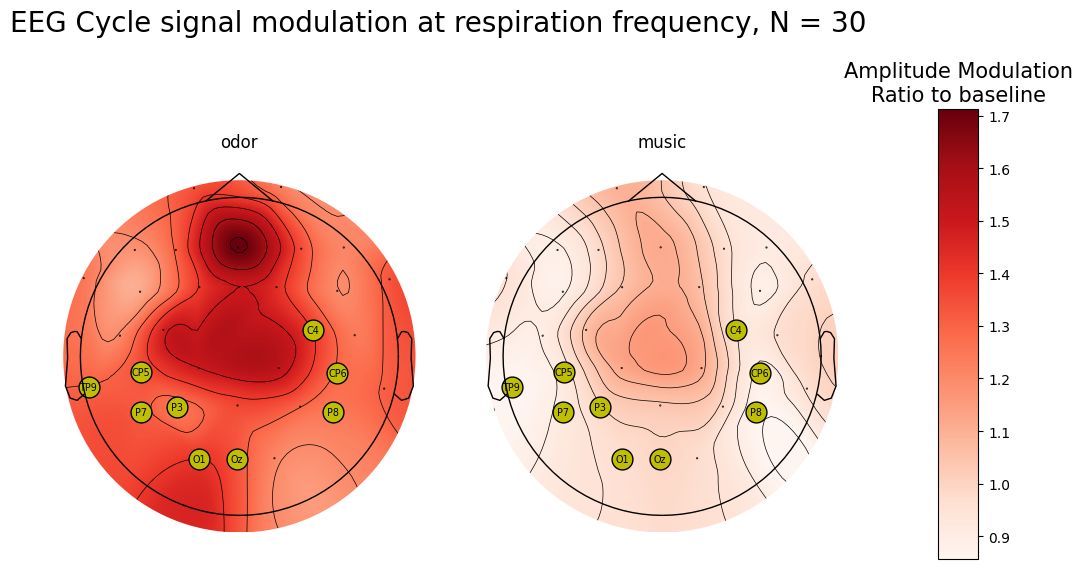

In [20]:
delta_quantile = 0.

colname = 'amplitude'

df = modulation_baselined

df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = colname, subject = 'participant')

N = modulation_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG Cycle signal modulation, N = {N}', fontsize = 20, y = 1.2)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Amplitude Modulation\nRatio to baseline',fontsize=15)

file = base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'cycle_signal_all.png'

fig.savefig(file, bbox_inches = 'tight')

In [22]:
delta_quantile = 0.

colname = 'amplitude'

for subject in subject_keys:
    
    df = modulation_baselined[modulation_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG Cycle Signal Modulation, sub = {subject}', fontsize = 20, y = 1.2)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Amplitude Modulation\nRatio to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'by_subject' / f'{subject}.png'

    fig.savefig(file, bbox_inches = 'tight')
    
    plt.close()